Let's get alerts from RADD, DETER, MapBiomas and GLAD for an AOI. Download, visualize, compare.

In [31]:
import os
import json
import pprint
import requests
from requests import Response
from typing import List, Set, Dict, Any, Tuple

import shapely
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, shape
from geopandas import GeoDataFrame

from typing import Dict




I need to define the AOI and the time period. I pick the AOI by looking at the distribution of alerts in QGIS. As for date, let's start with 2021.

<AxesSubplot:>

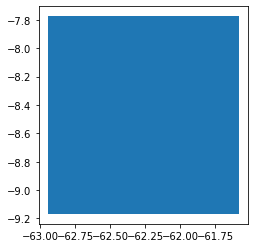

In [2]:


bb: Tuple[int] = (-7006677,-1024964, -6855473,-868057)
epsg: int = 3857

aoi: Polygon = Polygon([ [bb[0], bb[1]], [bb[0], bb[3]], [bb[2], bb[3]], [bb[2],bb[1]]])

aoi_gdf: GeoDataFrame = gpd.GeoDataFrame([], geometry=[aoi], crs=epsg)
aoi_gdf = aoi_gdf.to_crs(4326)
aoi_gdf.plot()

In [22]:
aoi_gdf.geometry.to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-62.942050399887165, -9.168032980041682], [-62.942050399887165, -7.7739263440393875], [-61.58376175768708, -7.7739263440393875], [-61.58376175768708, -9.168032980041682], [-62.942050399887165, -9.168032980041682]]]}, "bbox": [-62.942050399887165, -9.168032980041682, -61.58376175768708, -7.7739263440393875]}], "bbox": [-62.942050399887165, -9.168032980041682, -61.58376175768708, -7.7739263440393875]}'

In [3]:
aoi_gdf.to_crs(3857).area[0]

23724966028.000145

1. RADD alerts

In [4]:
version: str = 'v20220130'
dataset_name: str = 'wur_radd_alerts'

api_key: str = '4d824101-4456-441e-82c1-005ff1fd0e41'

geojson: Dict[str, Any] = { "type": "Polygon", "coordinates": [[ [-62.942050399887165, -9.168032980041682], [-62.942050399887165, -7.7739263440393875], [-61.58376175768708, -7.7739263440393875], [-61.58376175768708, -9.168032980041682], [-62.942050399887165, -9.168032980041682] ]] }
polygon_shape = shape(geojson)
sql: str = "SELECT longitude, latitude, wur_radd_alerts__date, wur_radd_alerts__confidence FROM results WHERE wur_radd_alerts__date >= '2021-01-01' AND wur_radd_alerts__date <='2021-03-31'"

In [44]:
body: Dict[str, str] = {'geometry' : geojson, 'sql' : sql}
body_encoded: str = json.dumps(body).encode('utf-8')
headers: Dict[str, str] = {'Content-Type': 'application/json', 'x-api-key' : api_key}

url_data_request: str = f'https://data-api.globalforestwatch.org/dataset/{dataset_name}/{version}/query'

In [45]:
resp = requests.post(url_data_request, data=body_encoded, headers=headers)
resp


<AxesSubplot:>

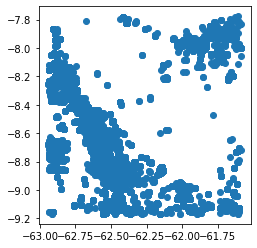

In [54]:
alerts_data = json.loads(resp.text)
alerts_df = pd.DataFrame(alerts_data['data'])
gdf = gpd.GeoDataFrame(alerts_df, geometry=gpd.points_from_xy(alerts_df.longitude, alerts_df.latitude))
gdf = gdf.drop(['latitude', 'longitude'], axis=1)
gdf.crs = 4326
gdf.plot()

In [57]:
gdf.to_file('sample_data/RADD_Q1_2021.gpkg', driver='GPKG')

/Users/janpisl/opt/anaconda3/envs/env-py-3.8/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


2. GLAD

There are many datasets that contains "GLAD". I am not sure which one to choose. Some candidates:

umd_glad_landsat_alerts\
umd_glad_sentinel2_alerts

geostore__glad__daily_alerts


In [7]:
dataset_name_glad_landsat = 'umd_glad_landsat_alerts'
field_url = f'https://data-api.globalforestwatch.org/dataset/{dataset_name_glad_landsat}/latest/fields'
resp = requests.get(field_url)
resp.raise_for_status()
fields = json.loads(resp.text)
for field in fields['data']:
    print(field['field_name'])

Some of the fields in am interested in:

umd_glad_landsat_alerts__date \
umd_glad_landsat_alerts__date_conf\
umd_glad_landsat_alerts__confidence
plus latitude, longitude that are not on the list

In [5]:
sql_glad_landsat: str = "SELECT longitude, latitude, umd_glad_landsat_alerts__date, umd_glad_landsat_alerts__date_conf,umd_glad_landsat_alerts__confidence FROM results WHERE umd_glad_landsat_alerts__date >= '2021-01-01' AND umd_glad_landsat_alerts__date <='2021-03-31'"

In [36]:
def request_gfw_dataset(api_key: str,
                        dataset_name: str,
                        version: str,
                        aoi: Polygon,
                        query: str
                        ) -> Response:
    """Request a dataset from Global Forest Watch.
    For more information and details on how to get the input parameters, visit:
    https://www.globalforestwatch.org/help/developers/guides/query-data-for-a-custom-geometry/

    Args:
        api_key (str):
            Global Forest Watch API key
        dataset_name (str):
            name of dataset to be requested
        version (str):
            version of the dataset
        aoi (shapely.geometry.Polygon):
            area of interest
        query (str):
            SQL query to select desired data

    Returns:
        requests.Response:
            The object returned by the request
    """

    geometry: str = shapely.geometry.mapping(aoi)

    body: Dict[str, str] = {'geometry' : geometry, 'sql' : query}
    body_encoded: str = json.dumps(body).encode('utf-8')
    headers: Dict[str, str] = {'Content-Type': 'application/json', 'x-api-key' : api_key}

    url_data_request: str = f'https://data-api.globalforestwatch.org/dataset/{dataset_name}/{version}/query'

    resp = requests.post(url_data_request, data=body_encoded, headers=headers)
    
    if int(resp.status_code) >= 400:
        pprint.pprint(json.loads(resp.text))
        raise Exception(f"Request failed")
        

    return resp

In [19]:
glad_response = request_gfw_dataset(api_key, dataset_name_glad_landsat, 'latest', polygon_shape, sql_glad_landsat)


<AxesSubplot:>

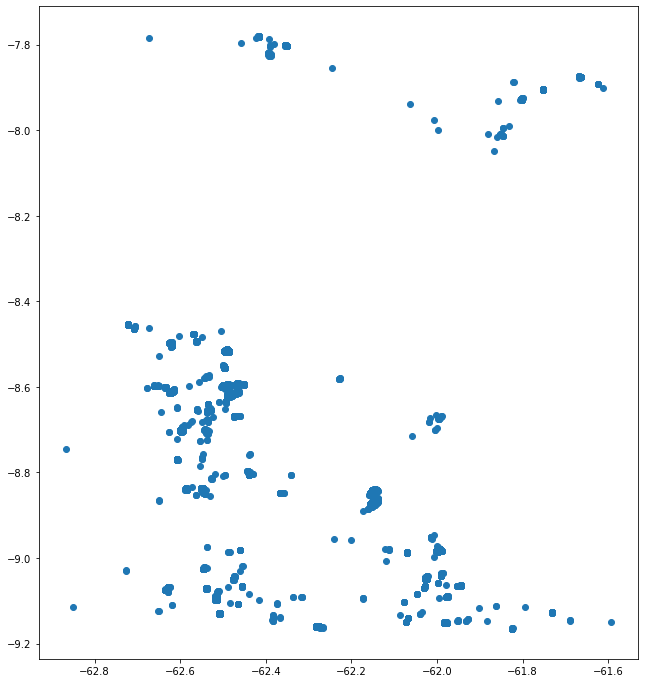

In [21]:
alerts_data = json.loads(glad_response.text)
glad_alerts_df = pd.DataFrame(alerts_data['data'])
glad_gdf = gpd.GeoDataFrame(glad_alerts_df, geometry=gpd.points_from_xy(glad_alerts_df.longitude, glad_alerts_df.latitude))
glad_gdf = glad_gdf.drop(['latitude', 'longitude'], axis=1)
glad_gdf.plot(figsize=(12,12))

In [23]:
glad_gdf.to_file('sample_data/GLAD_landsat_Q1_2021.gpkg', driver='GPKG')

/Users/janpisl/opt/anaconda3/envs/env-py-3.8/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Let's do the same for GLAD S-2

In [24]:
dataset_name_glad_s2 = 'umd_glad_sentinel2_alerts'
field_url = f'https://data-api.globalforestwatch.org/dataset/{dataset_name_glad_s2}/latest/fields'
resp = requests.get(field_url)
resp.raise_for_status()
fields = json.loads(resp.text)
for field in fields['data']:
    print(field['field_name'])

is__gfw_peatlands
mapbox_river_basins__id
whrc_aboveground_biomass_stock_2000__Mg_ha-1
whrc_aboveground_biomass_stock_2000__Mg
is__umd_regional_primary_forest_2001
wdpa_protected_areas__iucn_cat
rspo_oil_palm__certification_status
is__gfw_oil_gas
is__birdlife_alliance_for_zero_extinction_sites
is__birdlife_key_biodiversity_areas
rspo_southeast_asia_land_cover_2010__class
idn_forest_area__class
inpe_prodes__year
ifl_intact_forest_landscapes__year
is__gfw_mining_concessions
gfw_deadwood_carbon__Mg_CO2_ha-1
gfw_deadwood_carbon__Mg_CO2
gfw_litter_carbon__Mg_CO2_ha-1
gfw_litter_carbon__Mg_CO2
is__gmw_global_mangrove_extent_2016
ibge_bra_biomes__name
is__gfw_land_rights
gfw_litter_carbon__category
tsc_tree_cover_loss_drivers__driver
is__gfw_resource_rights
is__gmw_global_mangrove_extent_1996
gfw_aboveground_carbon__Mg_CO2_ha-1
gfw_aboveground_carbon__Mg_CO2
gfw_belowground_carbon__Mg_CO2_ha-1
gfw_belowground_carbon__Mg_CO2
gfw_radd_alerts__date_conf
gfw_radd_alerts__date
gfw_radd_alerts__con

In [27]:
# The fields are pretty much the same as for Landsat

sql_glad_s2: str = "SELECT longitude, latitude, umd_glad_sentinel2_alerts__date, umd_glad_sentinel2_alerts__date_conf,umd_glad_sentinel2_alerts__confidence FROM results WHERE umd_glad_sentinel2_alerts__date >= '2021-01-01' AND umd_glad_sentinel2_alerts__date <='2021-03-31'"

In [37]:
glad_response = request_gfw_dataset(api_key, dataset_name_glad_s2, 'latest', polygon_shape, sql_glad_s2)
alerts_data = json.loads(glad_response.text)
glad_alerts_df = pd.DataFrame(alerts_data['data'])
glad_gdf = gpd.GeoDataFrame(glad_alerts_df, geometry=gpd.points_from_xy(glad_alerts_df.longitude, glad_alerts_df.latitude))
glad_gdf = glad_gdf.drop(['latitude', 'longitude'], axis=1)
glad_gdf.plot(figsize=(12,12))

{'message': 'Raster analysis lambda received an unexpected response: {\n'
            '  "errorMessage": "Response payload size exceeded maximum allowed '
            'payload size (6291556 bytes).",\n'
            '  "errorType": "Function.ResponseSizeTooLarge"\n'
            '}',
 'status': 'error'}


Exception: Request failed

Request failed because of "Response payload size exceeded maximum allowed payload size (6291556 bytes)". I need to split the time. Let's try to split in half.

In [60]:
sql_glad_s2_1: str = "SELECT longitude, latitude, umd_glad_sentinel2_alerts__date, umd_glad_sentinel2_alerts__date_conf,umd_glad_sentinel2_alerts__confidence FROM results WHERE umd_glad_sentinel2_alerts__date >= '2021-10-01' AND umd_glad_sentinel2_alerts__date <='2021-10-03'"

In [61]:
glad_response = request_gfw_dataset(api_key, dataset_name_glad_s2, 'latest', polygon_shape, sql_glad_s2_1)
alerts_data = json.loads(glad_response.text)
glad_alerts_df = pd.DataFrame(alerts_data['data'])
glad_gdf = gpd.GeoDataFrame(glad_alerts_df, geometry=gpd.points_from_xy(glad_alerts_df.longitude, glad_alerts_df.latitude))
glad_gdf = glad_gdf.drop(['latitude', 'longitude'], axis=1)
glad_gdf.plot(figsize=(12,12))

{'message': 'Raster analysis lambda received an unexpected response: {\n'
            '  "errorMessage": "Response payload size exceeded maximum allowed '
            'payload size (6291556 bytes).",\n'
            '  "errorType": "Function.ResponseSizeTooLarge"\n'
            '}',
 'status': 'error'}


Exception: Request failed

Ok. This is not working. I keep getting the message about size being exceeded until I suddenly get an empty response.